In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import time
plt.style.use('ggplot')
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
data = pd.read_csv('card transaction cleaned.csv')

### Benford’s law variables

In [3]:
bf = data.copy()

In [4]:
bf['amount_100'] = (bf['Amount'] * 100).astype(str)
bf['first_digit'] = bf['amount_100'].str[0]
dropfedex = bf[bf['Merch description'].str.contains('FEDEX')]
droplist = dropfedex.index.tolist()
bf1 = bf.drop(droplist)
bf1['bin'] = bf1['first_digit'].apply(lambda x:"low" if x=='1' else ("low" if x=="2" else "high"))


In [5]:
bf1.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_100,first_digit,bin
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,3142.0,3,high
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,17849.0,1,low
7,8,5142191182,1/1/10,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429.0,P,230.32,0,23032.0,2,low
8,9,5142258629,1/1/10,602608969534,FISHER SCI ATL,GA,30091.0,P,62.11,0,6211.0,6,high
13,14,5142124791,1/1/10,5725000466504,CDW*GOVERNMENT INC,IL,60061.0,P,106.89,0,10689.0,1,low


In [6]:
card_bf = bf1.groupby(['Cardnum', 'bin']).agg({'bin': ['count']}).reset_index()
card_bf.columns=['Cardnum', 'bin', 'count']
card_bf = card_bf.pivot_table(index='Cardnum', columns='bin', values='count', aggfunc='sum').reset_index()
card_bf.head()

bin,Cardnum,high,low
0,5142110002,NaN,1.0
1,5142110081,4.0,NaN
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,NaN,1.0


In [7]:
card_bf.columns=['Cardnum', 'n_high', 'n_low']
card_bf = card_bf.fillna(1)
card_bf.head()

,Cardnum,n_high,n_low
0,5142110002,1.0,1.0
1,5142110081,4.0,1.0
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,1.0,1.0


In [8]:
# calculating R, 1/R, U, n, t U_smoothed
import math
c=3
n_mid=15
card_bf['R'] = (1.096 * card_bf['n_low']/card_bf['n_high'])
card_bf['1/R'] = (1/card_bf['R'])
card_bf['U'] = list(map(lambda x,y: max(x,y),card_bf['R'],card_bf['1/R']))
card_bf['n'] = card_bf['n_high'] + card_bf['n_low']
card_bf['t'] = ((card_bf['n'] - n_mid)/c)
card_bf['U_smoothed'] = list(map(lambda x, y: (1+(x-1)/(1+math.exp(-y))), card_bf['U'],card_bf['t']))
card_bf['U_smoothed'] = card_bf['U_smoothed']
card_bf.head()                         

,Cardnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,5142110002,1.0,1.0,1.096,0.912409,1.096000,2.0,-4.333333,1.001244
1,5142110081,4.0,1.0,0.274,3.649635,3.649635,5.0,-3.333333,1.091267
2,5142110313,1.0,2.0,2.192,0.456204,2.192000,3.0,-4.000000,1.021440
3,5142110402,8.0,3.0,0.411,2.433090,2.433090,11.0,-1.333333,1.298955
4,5142110434,1.0,1.0,1.096,0.912409,1.096000,2.0,-4.333333,1.001244


In [9]:
merch_bf = bf1.groupby(['Merchnum', 'bin']).agg({'bin': ['count']}).reset_index()
merch_bf.columns=['Merchnum', 'bin', 'count']
merch_bf = merch_bf.pivot_table(index='Merchnum', columns='bin', values='count', aggfunc='sum').reset_index()
merch_bf.head()

bin,Merchnum,high,low
0,003100006NOT6,1.0,NaN
1,004740006ABC6,NaN,1.0
2,005590006PNB6,1.0,NaN
3,014430619 14,NaN,1.0
4,014938913 51,1.0,NaN


In [10]:
merch_bf.columns=['Merchnum', 'n_high', 'n_low']
merch_bf = merch_bf.fillna(1)
merch_bf.head()

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,1.0
1,004740006ABC6,1.0,1.0
2,005590006PNB6,1.0,1.0
3,014430619 14,1.0,1.0
4,014938913 51,1.0,1.0


In [11]:
# calculating R, 1/R, U, n, t U_smoothed
c=3
n_mid=15
merch_bf['R'] = (1.096 * merch_bf['n_low']/merch_bf['n_high'])
merch_bf['1/R'] = (1/merch_bf['R'])
merch_bf['U'] = list(map(lambda x,y: max(x,y),merch_bf['R'], merch_bf['1/R']))
merch_bf['n'] = merch_bf['n_high'] + merch_bf['n_low']
merch_bf['t'] = ((merch_bf['n'] - n_mid)/c)
merch_bf['U_smoothed'] = list(map(lambda x, y: (1+(x-1)/(1+math.exp(-y))), merch_bf['U'],merch_bf['t']))
merch_bf['U_smoothed'] = merch_bf['U_smoothed']
merch_bf.head()      


,Merchnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,003100006NOT6,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244
1,004740006ABC6,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244
2,005590006PNB6,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244
3,014430619 14,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244
4,014938913 51,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244


In [12]:
card_bf['Cardnum'] = card_bf['Cardnum'].apply(str)
merch_bf['Merchnum'] = merch_bf['Merchnum'].apply(str)

In [13]:
card_bf.head()

,Cardnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,5142110002,1.0,1.0,1.096,0.912409,1.096000,2.0,-4.333333,1.001244
1,5142110081,4.0,1.0,0.274,3.649635,3.649635,5.0,-3.333333,1.091267
2,5142110313,1.0,2.0,2.192,0.456204,2.192000,3.0,-4.000000,1.021440
3,5142110402,8.0,3.0,0.411,2.433090,2.433090,11.0,-1.333333,1.298955
4,5142110434,1.0,1.0,1.096,0.912409,1.096000,2.0,-4.333333,1.001244


In [14]:
card_bf.set_index('Cardnum', inplace=True)
card_Ustar = pd.DataFrame(card_bf['U_smoothed'])
card_Ustar.sort_values(['U_smoothed'], ascending=False).head(3)

,U_smoothed
Cardnum,
5142253356,13.371199
5142299705,9.027976
5142197563,8.150852


In [15]:
merch_bf.set_index('Merchnum', inplace=True)
merch_Ustar = pd.DataFrame(merch_bf['U_smoothed'])
merch_Ustar.sort_values(['U_smoothed'], ascending=False).head(3)

,U_smoothed
Merchnum,
991808369338,165.145985
8078200641472,64.663981
308904389335,48.357557


In [16]:
# will be added to the DataFrame in the end
# final = final.merge(card_Ustar, how='left', left_on='Cardnum', right_on = card_Ustar.index)
# final = final.remane(columns={'U_smoothed': 'U*_cardnum'})
# final = final.merge(merch_Ustar, how='left', left_on='Merchnum', right_on = merch_Ustar.index)
# final = final.remane(columns={'U_smoothed': 'U*_merchnum'})
# final.head()

### Build variable

In [17]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [18]:
data['Date'] =  pd.to_datetime(data['Date'])

In [19]:
#Day of week variable
data['dow']=data.Date.apply(lambda x: calendar.day_name[x.weekday()])

In [20]:
# Separate the OOT
train_set=data[data.Date<'2010-11-01']

In [21]:
#Statistical Smoothing
c=4
nmid=20
y_avg=train_set['Fraud'].mean()
y_dow=train_set.groupby('dow')['Fraud'].mean()
num=train_set.groupby('dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
data['dow_risk']=data.dow.map(y_dow_smooth)

In [22]:
y_dow=y_dow.reset_index()
cats=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['dow']=pd.Categorical(y_dow['dow'],categories=cats,ordered=True)
y_dow=y_dow.sort_values('dow')
y_dow=y_dow.set_index('dow')

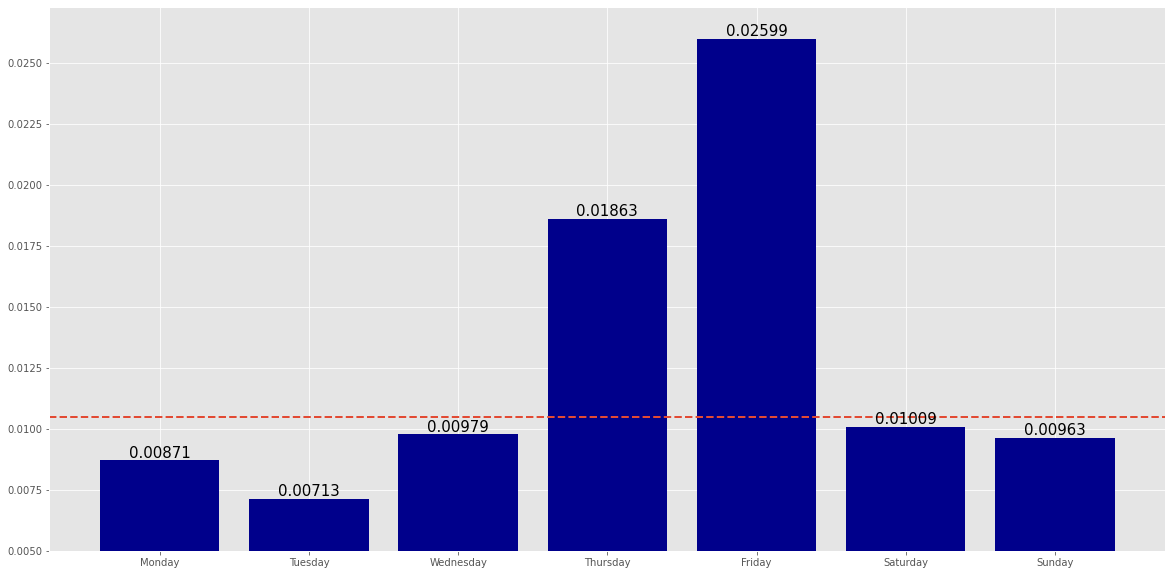

In [23]:
#plot
fig,ax=plt.subplots(figsize=(20,10))
plt.bar(data=y_dow,x=y_dow.index,height='Fraud',color='darkblue')
ax.set_ylim(bottom=0.005)
ax.axhline(y=y_avg,ls='--',lw=2)

for i in (y_dow.index):
    ax.text(i,y_dow.loc[i,'Fraud']+0.0001,round(y_dow.loc[i,'Fraud'],5),horizontalalignment='center',fontsize=15)


plt.savefig('risktable.png')
plt.show()

In [24]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.025994
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.025994
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994


In [25]:
df1 = data.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum

In [26]:
df1.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'dow',
       'dow_risk', 'check_date', 'check_record'],
      dtype='object')

In [27]:
df1.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,check_date,check_record
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,2010-01-01,1
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.025994,2010-01-01,2
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.025994,2010-01-01,3
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,2010-01-01,4
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,2010-01-01,5


In [28]:
# Make new entities for variables
# Make as many entities as could be useful 
# (cardnum, merchnum, card_merch, card_zip, card_state, merch_zip, merch_state…)

df1['card_merch'] = str(df1.Cardnum) + df1.Merchnum
df1['card_zip'] = str(df1.Cardnum) + df1['Merch zip']
df1['card_state'] = str(df1.Cardnum) + df1['Merch state']
df1['merch_zip'] = df1.Merchnum + df1['Merch zip']
df1['merch_state'] = df1.Merchnum + df1['Merch state']


In [29]:
df1.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'dow',
       'dow_risk', 'check_date', 'check_record', 'card_merch', 'card_zip',
       'card_state', 'merch_zip', 'merch_state'],
      dtype='object')

In [30]:
final = df1.copy()

In [31]:
final.shape

(96397, 19)

In [32]:
entities = list(final.iloc[:,np.r_[1, 3:7, 14:19]].columns)

In [33]:
entities

['Cardnum',
 'Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state']

In [34]:
import timeit
start = timeit.default_timer()
for entity in entities:    
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    
    ## Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')   
    ## Frequency & Amount variables:   
    for time in [0,1,3,7,14,30]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')




Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Run time for the last entity ----------------- 7.326636559999999s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount variables over past 14 ---> Done
Merchnum_count_30 ---> Done
Merchnum amount variables o

In [35]:
final.shape

(96397, 569)

In [36]:
start = timeit.default_timer()
# velocity change variables
for ent in entities:
    for d in ['0','1']:
        for dd in ['7', '14', '30']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            


In [37]:
final.shape

(96397, 629)

In [38]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merch_zip_count_0_by_30,merch_zip_count_1_by_7,merch_zip_count_1_by_14,merch_zip_count_1_by_30,merch_state_count_0_by_7,merch_state_count_0_by_14,merch_state_count_0_by_30,merch_state_count_1_by_7,merch_state_count_1_by_14,merch_state_count_1_by_30
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333


In [39]:
start = timeit.default_timer()
# velocity days since ratio
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_vdratio_' + d ] =\
            final[ent + '_count_' + d + '_by_' + dd]/(final[ent + '_day_since']+1)



In [40]:
final.shape

(96397, 649)

In [41]:
final['card_merch'] = str(final.Cardnum) + final.Merchnum
final['card_zip'] = str(final.Cardnum) + final['Merch zip']
final['card_state'] = str(final.Cardnum) + final['Merch state']
final['merch_zip'] = final.Merchnum + final['Merch zip']
final['merch_state'] = final.Merchnum + final['Merch state']

In [42]:
# Cross entity uniqueness variables
for entity in entities: 
    for field in entities:
        st = timeit.default_timer()
        if entity != field:
            new_attributes = f'{entity}_{field}_nunique'
            if new_attributes not in list(final.columns):
                mapper3 = final.groupby(entity)[field].nunique()
                final[new_attributes] = final[entity].map(mapper3)
        print(f'Run time for entity {entity} in field {field}'+ ' ---> Done')
            


Run time for entity Cardnum in field Cardnum ---> Done
Run time for entity Cardnum in field Merchnum ---> Done
Run time for entity Cardnum in field Merch description ---> Done
Run time for entity Cardnum in field Merch state ---> Done
Run time for entity Cardnum in field Merch zip ---> Done
Run time for entity Cardnum in field card_merch ---> Done
Run time for entity Cardnum in field card_zip ---> Done
Run time for entity Cardnum in field card_state ---> Done
Run time for entity Cardnum in field merch_zip ---> Done
Run time for entity Cardnum in field merch_state ---> Done
Run time for entity Merchnum in field Cardnum ---> Done
Run time for entity Merchnum in field Merchnum ---> Done
Run time for entity Merchnum in field Merch description ---> Done
Run time for entity Merchnum in field Merch state ---> Done
Run time for entity Merchnum in field Merch zip ---> Done
Run time for entity Merchnum in field card_merch ---> Done
Run time for entity Merchnum in field card_zip ---> Done
Run tim

In [43]:
final.shape

(96397, 739)

In [44]:
# frequencies
df2 = data.copy()
df2['check_date'] = df2.Date
df2['check_recnum'] = df2.Recnum
df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum']]
df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
temp2 = pd.merge(df_2, df_s, left_on = 'Cardnum', right_on = 'Cardnum')

#Frequency Mappers
# groupers = ['Cardnum', 'Merchnum']
groupers = ['Cardnum']
for grouper in groupers: 
    for d in [0,1]:
        for dd in [3,7,14,30]:
            numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))
                               & (temp2.Recnum >= temp2.check_recnum)]
            denominator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(dd)))
                               & (temp2.Recnum >= temp2.check_recnum)]

            numerator = numerator_df.groupby(grouper)['Recnum'].count()
            denominator = denominator_df.groupby(grouper)['Recnum'].count()/dd

            colname = 'relative_velocity_count_by_' + grouper + '_' + str(d) + '_days_over_' + str(dd)

            final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)


In [45]:
final.shape

(96397, 747)

In [46]:
# variability
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: 
        print('')
    st = timeit.default_timer() 
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    for time in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
 


Run time for the last entity ----------------- 12.696925942999997s
Cardnum_variability_avg_0 ---> Done
Cardnum_variability_max_0 ---> Done
Cardnum_variability_med_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_variability_avg_1 ---> Done
Cardnum_variability_max_1 ---> Done
Cardnum_variability_med_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_variability_avg_3 ---> Done
Cardnum_variability_max_3 ---> Done
Cardnum_variability_med_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_variability_avg_7 ---> Done
Cardnum_variability_max_7 ---> Done
Cardnum_variability_med_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_variability_avg_14 ---> Done
Cardnum_variability_max_14 ---> Done
Cardnum_variability_med_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_variability_avg_30 ---> Done
Cardnum_variability_max_30 ---> Done
Cardnum_variability_med_30 ---> Done
Cardnum amount variables over past 30 ---> 

card_state_variability_avg_14 ---> Done
card_state_variability_max_14 ---> Done
card_state_variability_med_14 ---> Done
card_state amount variables over past 14 ---> Done
card_state_variability_avg_30 ---> Done
card_state_variability_max_30 ---> Done
card_state_variability_med_30 ---> Done
card_state amount variables over past 30 ---> Done
Run time for the last entity ----------------- 683.936729518s
merch_zip_variability_avg_0 ---> Done
merch_zip_variability_max_0 ---> Done
merch_zip_variability_med_0 ---> Done
merch_zip amount variables over past 0 ---> Done
merch_zip_variability_avg_1 ---> Done
merch_zip_variability_max_1 ---> Done
merch_zip_variability_med_1 ---> Done
merch_zip amount variables over past 1 ---> Done
merch_zip_variability_avg_3 ---> Done
merch_zip_variability_max_3 ---> Done
merch_zip_variability_med_3 ---> Done
merch_zip amount variables over past 3 ---> Done
merch_zip_variability_avg_7 ---> Done
merch_zip_variability_max_7 ---> Done
merch_zip_variability_med_7 ---

In [47]:
final.shape

(96397, 927)

In [48]:
for i in entities:
    for v in entities:
        if i==v:
            continue
        else:
            df_c=df1[['Recnum','Date',i]]
            df_d=df1[['check_record','check_date',i,v]]
            temp=pd.merge(df_c,df_d,left_on=i,right_on=i)
            
        for t in [1,3,7,14,30,60]:
            count_day_df=temp[(temp.check_date>=(temp.Date-dt.timedelta(t)))&(temp.Recnum>=temp.check_record)]
            col_name=f'{i}_unique_count_for_{v}_{t}'
            mapper=count_day_df.groupby(['Recnum'])[v].nunique()
            final[col_name]=final.Recnum.map(mapper)


In [49]:
final.shape

(96397, 1467)

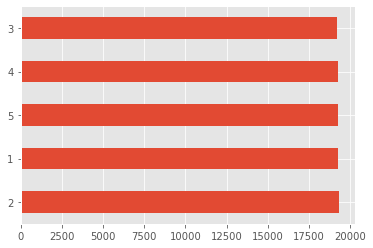

In [50]:
# Amount bins
AMOUNT = True
if AMOUNT:
    final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])
    final['amount_cat'].value_counts().plot(kind='barh')
    plt.show()
    qcut_series, qcut_intervals = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5],retbins=True)
    qcut_series.value_counts()


In [51]:
final.shape

(96397, 1468)

In [52]:
# acceleration
for ent in entities:
    print(ent)
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)


Cardnum
Merchnum
Merch description
Merch state
Merch zip
card_merch
card_zip
card_state
merch_zip
merch_state


In [53]:
final.shape

(96397, 1528)

In [54]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merch_zip_count_0_by_30_sq,merch_zip_count_1_by_7_sq,merch_zip_count_1_by_14_sq,merch_zip_count_1_by_30_sq,merch_state_count_0_by_7_sq,merch_state_count_0_by_14_sq,merch_state_count_0_by_30_sq,merch_state_count_1_by_7_sq,merch_state_count_1_by_14_sq,merch_state_count_1_by_30_sq
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111


In [55]:
final.to_csv('card_vars.csv')

### Add BL variables

In [56]:
finalBL = final.copy()

In [57]:
card_Ustar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1640 entries, 5142110002 to 5142847398
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   U_smoothed  1640 non-null   float64
dtypes: float64(1)
memory usage: 25.6+ KB


In [58]:
card_Ustar.index = card_Ustar.index.astype(int)

In [59]:
card_Ustar.index.dtype

dtype('int64')

In [60]:
merch_Ustar.index.dtype

dtype('O')

In [61]:
finalBL['Cardnum'].dtype

dtype('int64')

In [62]:
finalBL = finalBL.merge(card_Ustar, how='left', left_on='Cardnum', right_on = card_Ustar.index)
finalBL = finalBL.rename(columns={'U_smoothed': 'U*_cardnum'})
finalBL = finalBL.merge(merch_Ustar, how='left', left_on='Merchnum', right_on = merch_Ustar.index)
finalBL = finalBL.rename(columns={'U_smoothed': 'U*_merchnum'})
finalBL.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merch_zip_count_1_by_14_sq,merch_zip_count_1_by_30_sq,merch_state_count_0_by_7_sq,merch_state_count_0_by_14_sq,merch_state_count_0_by_30_sq,merch_state_count_1_by_7_sq,merch_state_count_1_by_14_sq,merch_state_count_1_by_30_sq,U*_cardnum,U*_merchnum
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,2.178008,NaN
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,1.604857,1.001244
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,2.368143,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,1.044105,NaN
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,2.178008,NaN


In [63]:
finalBL.to_csv('card_vars_BL.csv')